In [1]:
import datetime
import json
import os
from collections import defaultdict
import gc
from joblib import dump, load
import random
import time
from typing import List, Tuple

from albumentations import (
    Compose, Flip, Rotate
)

import cv2
import dask
import dask.array as da

from google.cloud import storage
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, precision_score, precision_recall_curve

import tensorflow as tf
from tensorflow.keras.applications import inception_v3, resnet_v2
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.metrics import Accuracy, binary_crossentropy

from data_engineering.dask_image_stats_collector import stats_for_numpy_images 
from data_science.keras.dataset import get_image_dataset, get_predictions_for_dataset
from data_science.graph_utils import graph_model_history
from data_science.keras.model_checkpoint_gcs import ModelCheckpointGCS
from data_science.keras.cnn_models import basic_cnn_model, basic_cnn_model_with_regularization, pretrained_model
from data_science.serialization_utils import numpy_to_json, sklearn_precision_recall_curve_to_dict
from data_science.sklearn_batch_generator import SklearnBatchGenerator
from data_science.train import get_model_and_metadata_from_gcs, train_keras_model

In [2]:
root = '/home/jovyan/work/data/big_earth'
os.listdir(root)

random_seed = 0
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/app/.gcs/big-earth-252219-fb2e5c109f78.json'
gcs_client = storage.Client()
bucket = gcs_client.bucket("big_earth")

n_classes = 1
n_epochs = 100
batch_size = 128

early_stopping_patience = 6
use_small_dataset = False
use_random_small_dataset = False

project_name = "cloud_and_shadow"
model_dir = os.path.join(root, "model/models")
log_dir = os.path.join(root, "model/logs")
# blob prefix
gcs_model_dir = "model/models"
# tensorboard
gcs_log_dir = "gs://big_earth/model/logs"

for directory in [log_dir, model_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory, exist_ok=True)
        
        
# np.array(json.loads(df['binarized_labels'].iloc[0])).shape

def prepare_data(df):
    df['has_cloud_and_shadow_target'] = df['has_cloud_and_shadow_target'].apply(lambda x: np.array(json.loads(x)))
    df['binarized_labels'] = df['binarized_labels'].apply(lambda x: np.array(json.loads(x)))    
    df['image_path'] = root + "/npy_image_files/" + df['image_prefix'] + ".npy"
    return df

df = pd.read_csv(root + "/metadata/metadata.csv")
df = prepare_data(df)
print(df['binarized_labels'].iloc[0].shape)
print(df['has_cloud_and_shadow_target'].iloc[0].shape)
df = df.set_index('image_prefix', drop=False)

google_automl_dataset = pd.read_csv( '/app/data_science/google_automl_cloud_and_shadow_dataset_small.csv')
google_automl_dataset['image_prefix'] = google_automl_dataset['gcs_uri'].str.split('/').apply(lambda x: x[-1].replace(".png", ""))
google_automl_dataset = google_automl_dataset.set_index('image_prefix', drop=False)

train = df.loc[google_automl_dataset[google_automl_dataset['set'] == 'TRAIN'].index]
valid = df.loc[google_automl_dataset[google_automl_dataset['set'] == 'VALIDATION'].index]
test = df.loc[google_automl_dataset[google_automl_dataset['set'] == 'TEST'].index]

print(len(train), len(valid), len(test))
print(len(train) + len(valid) + len(test) == len(google_automl_dataset))

if os.path.exists(root + '/cloud_and_shadow_stats.csv'):
    all_stats = pd.read_csv(root + '/cloud_and_shadow_stats.csv')
else:
    stat_list = []
    npy_image_dir = root + "/npy_image_files"
    npy_files = [npy_image_dir + "/" + file + ".npy" for file in train['image_prefix'].values]
    start = time.time()
    stats = stats_for_numpy_images(npy_files,  use_test_data=False)
    stats['data'] = 'all'
    stat_list.append(stats)
    
    # get stats per class
    no_cloud = train[train['has_cloud_and_shadow'] == 0]
    cloud = train[train['has_cloud_and_shadow'] == 1]
    print(len(no_cloud), len(cloud))

    for name, data in [('no_cloud', no_cloud), ('cloud', cloud)]:
        npy_files = [npy_image_dir + "/" + file + ".npy" for file in data['image_prefix'].values]
        stats = stats_for_numpy_images(npy_files,  use_test_data=False)
        stats['data'] = name
        stat_list.append(stats)    
    
    all_stats = pd.concat(stat_list)
    all_stats['band'] = all_stats.index
    all_stats = all_stats.reset_index()  
    all_stats = all_stats.drop('index', axis=1)    
    all_stats.to_csv(root + '/cloud_and_shadow_stats.csv', index=False)
        
    print(f'stats computed in {time.time() - start}')

band_stats = all_stats[all_stats['data'] == 'all']    

x_train = train['image_path'].values
x_valid = valid['image_path'].values
x_test = test['image_path'].values

target = 'has_cloud_and_shadow_target'
y_train = np.stack(train[target].values)
y_valid = np.stack(valid[target].values)
y_test = np.stack(test[target].values)

print(y_train.shape, y_train[0].shape)

if use_small_dataset:
    size = batch_size
    n_epochs = 3
    x_train = np.concatenate([x_train[:size], x_train[-size:]])
    x_valid = np.concatenate([x_valid[:size], x_valid[-size:]])
    x_test = np.concatenate([x_test[:size], x_test[-size:]])

    y_train = np.concatenate([y_train[:size], y_train[-size:]])
    y_valid = np.concatenate([y_valid[:size], y_valid[-size:]])
    y_test = np.concatenate([y_test[:size], y_test[-size:]])
elif use_random_small_dataset:
    shape = (100, 1)
    x_train = np.concatenate([np.ones(shape), np.zeros(shape)])
    y_train = np.concatenate([np.ones(shape), np.zeros(shape)])

    x_valid = np.concatenate([np.ones(shape), np.zeros(shape)])
    y_valid = np.concatenate([np.ones(shape), np.zeros(shape)])

    y_train = np.random.randint(0, 2, (len(train), 44))
    y_valid = np.random.randint(0, 2, (len(valid), 44))
    y_test = np.random.randint(0, 2, (len(test), 44))
    y_test_labels = test['labels'].values

print(y_train.shape, y_train[0].shape)

(1, 44)
(1,)
1907 253 240
True


KeyError: 'data'

In [10]:
experiment_name = f"{project_name}_basic_cnn_2020_1_31"
model_basic, model_base_metadata_basic = get_model_and_metadata_from_gcs(
    bucket, model_dir, "h5", load_model, gcs_model_dir, experiment_name)
model_base_metadata_basic

{'data': 'train_valid_google_automl_cloud_and_shadow_dataset_small.csv',
 'data_prep': 'normalization_augmentation',
 'experiment_name': 'cloud_and_shadow_basic_cnn_2020_1_31',
 'experiment_start_time': '2020-02-06 20:22',
 'model': 'keras_cnn',
 'random_state': 0,
 'epoch': 7,
 'history': {'loss': 0.3318435549736023, 'accuracy': 1.0},
 'elapsed_train_time': 19.615356922149658}

In [8]:
experiment_name = f"{project_name}_basic_cnn_with_regularization_2020_1_31"
model_reg, model_base_metadata_reg = get_model_and_metadata_from_gcs(
    bucket, model_dir, "h5", load_model, gcs_model_dir, experiment_name)

In [9]:
model_base_metadata_reg

{'data': 'train_valid_google_automl_cloud_and_shadow_dataset_small.csv',
 'data_prep': 'normalization_augmentation',
 'experiment_name': 'cloud_and_shadow_basic_cnn_with_regularization_2020_1_31',
 'experiment_start_time': '2020-02-06 22:18',
 'model': 'keras_cnn',
 'random_state': 0,
 'epoch': 31,
 'history': {'loss': 0.025802001101172402,
  'accuracy': 0.9921342134475708,
  'val_loss': 0.5104478299617767,
  'val_accuracy': 0.8339921236038208,
  'lr': 0.0003000000142492354},
 'elapsed_train_time': 245.4765522480011,
 'accuracy_train': 1.0,
 'accuracy_valid': 0.8063241106719368,
 'f1_score_train': 1.0,
 'f1_score_valid': 0.7822222222222223,
 'confusion_matrix': '{"data": [[116, 21], [28, 88]], "shape": [2, 2], "dtype": "int64"}',
 'precision_recall_curve': {'precision': '{"data": [0.45849802371541504, 0.8073394495412844, 1.0], "shape": [3], "dtype": "float64"}',
  'recall': '{"data": [1.0, 0.7586206896551724, 0.0], "shape": [3], "dtype": "float64"}',
  'threshold': '{"data": [0, 1], "s

In [6]:
experiment_name = f"{project_name}_basic_cnn_with_regularization_and_aug_2020_1_31"
model, model_base_metadata = get_model_and_metadata_from_gcs(
    bucket, model_dir, "h5", load_model, gcs_model_dir, experiment_name)

In [7]:
model_base_metadata

{'data': 'train_valid_google_automl_cloud_and_shadow_dataset_small.csv',
 'data_prep': 'normalization_augmentation',
 'experiment_name': 'cloud_and_shadow_basic_cnn_with_regularization_and_aug_2020_1_31',
 'experiment_start_time': '2020-02-06 21:49',
 'model': 'keras_cnn',
 'random_state': 0,
 'epoch': 40,
 'history': {'loss': 0.14880301142682814,
  'accuracy': 0.9402202367782593,
  'val_loss': 0.21924246847629547,
  'val_accuracy': 0.9288537502288818,
  'lr': 0.0003000000142492354},
 'elapsed_train_time': 317.83416533470154,
 'accuracy_train': 0.9328788673308862,
 'accuracy_valid': 0.9090909090909091,
 'f1_score_train': 0.9302832244008714,
 'f1_score_valid': 0.8977777777777779,
 'confusion_matrix': '{"data": [[129, 8], [15, 101]], "shape": [2, 2], "dtype": "int64"}',
 'precision_recall_curve': {'precision': '{"data": [0.45849802371541504, 0.926605504587156, 1.0], "shape": [3], "dtype": "float64"}',
  'recall': '{"data": [1.0, 0.8706896551724138, 0.0], "shape": [3], "dtype": "float64"}

In [ ]:
model.layers

In [ ]:
import numpy as np


def plot_activations(model, img):
    layer_names = []
    for layer in model.layers:
        layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot

    images_per_row = 12
    layer_outputs = [layer.output for layer in model.layers]
    activation_model = Model(inputs=model.input, outputs=layer_outputs)    
    activations = activation_model.predict(img)
    activations = activations
    for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
        if not 'conv2d' in layer_name:
            continue
        n_features = layer_activation.shape[-1] # Number of features in the feature map
        size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
        n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols): # Tiles each filter into a big horizontal grid
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                                 :, :,
                                                 col * images_per_row + row]
                channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size, # Displays the grid
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        
x_small = [x_train[5]]
y_small = [y_train[5]]     
train_batch_generator = get_image_dataset(x_small, y_small, augmentations=None, band_stats=stats, 
                                          batch_size=batch_size)
img, label = train_batch_generator.make_one_shot_iterator().get_next()

plot_activations(model, img)

In [ ]:
experiment_name = f"{project_name}_basic_cnn_with_regularization_and_aug_2020_1_31"
model, model_base_metadata = get_model_and_metadata_from_gcs(
    bucket, model_dir, "h5", load_model, gcs_model_dir, experiment_name)

In [ ]:
rgb_img = (img[0].numpy() * 1.6 * 256.).astype(np.int8)
plt.imshow(rgb_img)

In [ ]:
model_base_metadata

In [24]:
test_generator = get_image_dataset(x=x_test, y=y_test, augmentations=None, image_processor=None,
                                    band_stats=band_stats, batch_size=batch_size)
y_actual_test, y_pred_test, y_pred_probs_test = get_predictions_for_dataset(test_generator, model) 

print('binary_crossentropy - cnn with regularization and augmentation', 
      binary_crossentropy(y_actual_test, y_pred_probs_test).numpy())
print('accuracy', accuracy_score(y_actual_test, y_pred_test))

binary_crossentropy - cnn with regularization and augmentation 0.28754404
accuracy 0.8875


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f83031b1400>]],
      dtype=object)

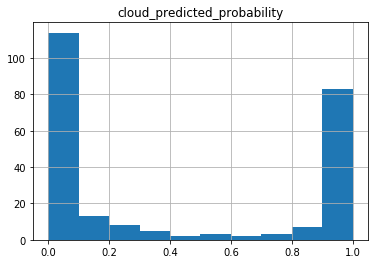

In [84]:
pd.DataFrame({'cloud_predicted_probability': y_pred_probs_test}).hist()

In [21]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [79]:
from sklearn.metrics import average_precision_score
average_precision_score(y_actual_test, y_pred_probs_test)

0.9696256560928516

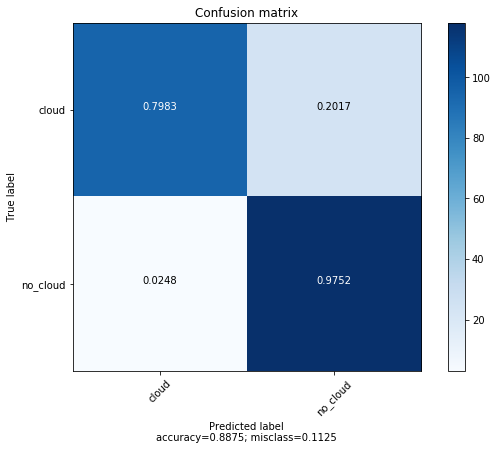

In [85]:
cm = confusion_matrix(y_actual_test, y_pred_test)
# Put in same format as google automl
cm = np.array(
    [[cm[1][1], cm[1][0]],
     [cm[0][1], cm[0][0]]
])
plot_confusion_matrix(cm, target_names=['cloud', 'no_cloud'],
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True)

In [44]:
df2 = df[~df.index.isin(google_automl_dataset.index)]
print(len(df), len(df2), len(df) - len(df2), len(google_automl_dataset))

test2_no_cloud = df2[df2['has_cloud_and_shadow'] == 0].sample(n=200, random_state=random_seed)
test2_cloud = df2[df2['has_cloud_and_shadow'] == 1].sample(n=200, random_state=random_seed)
test2 = pd.concat([test2_no_cloud, test2_cloud])
len(test2)

590326 587926 2400 2400


400

In [46]:
x_test2 = test2['image_path'].values
y_test2 = np.stack(test2[target].values)

test2_generator = get_image_dataset(x=x_test2, y=y_test2, augmentations=None, image_processor=None,
                                    band_stats=band_stats, batch_size=batch_size)
y_actual_test2, y_pred_test2, y_pred_probs_test2 = get_predictions_for_dataset(test2_generator, model) 

print('binary_crossentropy - cnn with regularization and augmentation', 
      binary_crossentropy(y_actual_test2, y_pred_probs_test2).numpy())
print('accuracy', accuracy_score(y_actual_test2, y_pred_test2))

binary_crossentropy - cnn with regularization and augmentation 0.3073066
accuracy 0.8825


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8303eb1b00>]],
      dtype=object)

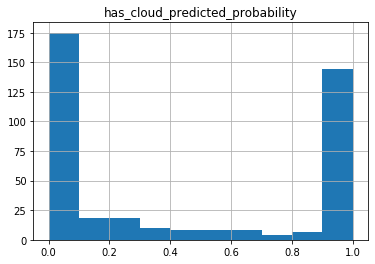

In [47]:
pd.DataFrame({'has_cloud_predicted_probability': y_pred_probs_test2}).hist()

In [55]:
precision, recall, f_score, support = sklearn.metrics.precision_recall_fscore_support(y_actual_test, y_pred_test, average='binary') 

In [68]:
precision, recall, thresholds = precision_recall_curve(y_actual_test, y_pred_probs_test)

In [69]:
precision = precision[:-1]
recall = recall[:-1]
df = pd.concat([
    pd.DataFrame({'stat_name': ['precision' for _ in range(len(precision))],
                  'stat_value': precision,
                  'threshold': thresholds}),
    pd.DataFrame({'stat_name': ['recall' for _ in range(len(precision))],
                  'stat_value': recall,
                  'threshold': thresholds})    
])

In [95]:
df2 = pd.DataFrame({'precision': precision, 'recall': recall, 'threshold': thresholds})
df2[df2['threshold'] > .05]

,precision,recall,threshold
80,0.740260,0.957983,0.050071
81,0.745098,0.957983,0.051856
82,0.750000,0.957983,0.051961
83,0.754967,0.957983,0.051974
84,0.760000,0.957983,0.052050
...,...,...,...
229,1.000000,0.042017,0.999835
230,1.000000,0.033613,0.999882
231,1.000000,0.025210,0.999943
232,1.000000,0.016807,0.999957


Text(0.5, 1.0, 'Precision/Recall per Threshold')

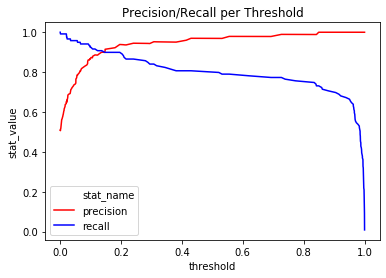

In [83]:
ax = sns.lineplot(y=df['stat_value'], x=df['threshold'], hue=df['stat_name'], 
                  palette={'precision': 'red', 'recall': 'blue'})
ax.set_title('Precision/Recall per Threshold')
# ax.fill_between(recall,precision, color="darkblue", alpha=0.3)

In [ ]:
# Hyperparameter tuning

In [15]:
iterator = bucket.list_blobs(prefix="model/models/", delimiter='/')
# response = iterator._get_next_page_response()
prefixes = set()

for page in iterator.pages:
    print(page, page.prefixes)
    prefixes.update(page.prefixes)

prefixes

<google.api_core.page_iterator.Page object at 0x7f140e486e80> ()


set()

In [16]:
experiments = [
    "cloud_and_shadow_cnn_bn_hopt_lr_0.00012387_optimizer_SGD_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.00015907_optimizer_SGD_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.0001945_optimizer_SGD_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.00023558_optimizer_SGD_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.00024361_optimizer_RMSprop_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.0002532_optimizer_SGD_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.00027934_optimizer_Adam_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.00037462_optimizer_RMSprop_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.00041657_optimizer_SGD_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.00043806_optimizer_RMSprop_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.00049497_optimizer_RMSprop_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.00057232_optimizer_Adam_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.00063454_optimizer_Adam_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.00065432_optimizer_Adam_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.00084517_optimizer_RMSprop_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.0008693_optimizer_RMSprop_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.00093852_optimizer_RMSprop_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.00136203_optimizer_RMSprop_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.00153225_optimizer_RMSprop_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.00168857_optimizer_RMSprop_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.00219341_optimizer_RMSprop_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.00244096_optimizer_RMSprop_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.00323063_optimizer_SGD_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.0035308_optimizer_Adam_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.00397654_optimizer_RMSprop_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.00496855_optimizer_RMSprop_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.00541214_optimizer_SGD_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.00882552_optimizer_RMSprop_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.00931584_optimizer_Adam_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.00973927_optimizer_RMSprop_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_1.032e-05_optimizer_RMSprop_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_1.146e-05_optimizer_Adam_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_1.296e-05_optimizer_RMSprop_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_2.053e-05_optimizer_RMSprop_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_2.086e-05_optimizer_RMSprop_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_2.383e-05_optimizer_Adam_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_3.665e-05_optimizer_Adam_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_4.39e-05_optimizer_RMSprop_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_5.246e-05_optimizer_RMSprop_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_5.635e-05_optimizer_RMSprop_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_5.673e-05_optimizer_RMSprop_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_5.984e-05_optimizer_Adam_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_8.667e-05_optimizer_RMSprop_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_9.781e-05_optimizer_RMSprop_2020_2_13",
]

In [41]:
results

{'data': 'train_valid_google_automl_cloud_and_shadow_dataset_small.csv',
 'data_prep': 'normalization_augmentation',
 'experiment_name': 'cloud_and_shadow_cnn_bn_hopt_lr_0.00057232_optimizer_Adam_2020_2_13',
 'experiment_start_time': '2020-02-14 02:42',
 'model': 'keras_cnn_bn',
 'random_state': 0,
 'epoch_with_best_model': '38',
 'epochs_trained': -1,
 'optimizer': 'Adam',
 'n_epochs': 60,
 'early_stopping_patience': 20,
 'learning_rate': 0.0005723163086187314,
 'history': {'loss': 0.1794100722906536,
  'accuracy': 0.9339276552200317,
  'val_loss': 0.21234557032585144,
  'val_accuracy': 0.9249011874198914,
  'lr': 0.0005723162903450429},
 'elapsed_train_time': 292.90803623199463}

In [42]:
len_one_keys = ['data', 'data_prep', 'experiment_name', 'experiment_start_time', 'model', 'random_state', 'epoch_with_best_model', 'epochs_trained', 'optimizer', 'n_epochs', 'early_stopping_patience', 'learning_rate', 'elapsed_train_time', 'accuracy_train', 'f1_score_train', 'train_loss', 'loss', 'accuracy_valid', 'f1_score_valid']
long_keys = ['history', 'confusion_matrix', 'precision_recall_curve', 'y_actual_train', 'y_pred_train', 'y_pred_probs_train', 'y_actual_valid', 'y_pred_valid', 'y_pred_probs_valid']
serializable_results_list = []

for experiment in experiments:
    local_filename = f'{experiment}.json'
    blob = bucket.blob(f"model/models/{experiment}_metadata.json")
    blob.download_to_filename(local_filename)

    with open(local_filename) as fileobj:
        results = json.load(fileobj)  

    try:
        serializable_results = {k: results[k] for k in len_one_keys}
        for key in long_keys:
            serializable_results[key] = json.dumps(results[key])
        serializable_results_list.append(serializable_results)
    except KeyError:
        print('keyerror')
        print(experiment)
    
df = pd.DataFrame(serializable_results_list, index=[num for num in range(len(serializable_results_list))])

keyerror
cloud_and_shadow_cnn_bn_hopt_lr_0.00057232_optimizer_Adam_2020_2_13


In [46]:
d = df[['optimizer', 'learning_rate', 'elapsed_train_time', 'n_epochs', 'accuracy_train', 'accuracy_valid']].sort_values(
    by='accuracy_valid', ascending=False)

In [71]:
d

,optimizer,learning_rate,elapsed_train_time,n_epochs,accuracy_train,accuracy_valid
12,Adam,0.000654,449.833595,60,0.916623,0.944664
17,RMSprop,0.001532,449.621799,60,0.937598,0.940711
26,RMSprop,0.008826,461.263601,60,0.907184,0.936759
13,RMSprop,0.000845,443.141953,60,0.934976,0.932806
28,RMSprop,0.009739,462.851124,60,0.908233,0.932806
4,RMSprop,0.000244,457.263501,60,0.947037,0.928854
22,Adam,0.003531,453.618174,60,0.909282,0.928854
9,RMSprop,0.000438,457.330245,60,0.945464,0.928854
23,RMSprop,0.003977,390.569443,60,0.905611,0.924901
11,Adam,0.000635,400.926325,60,0.912952,0.924901


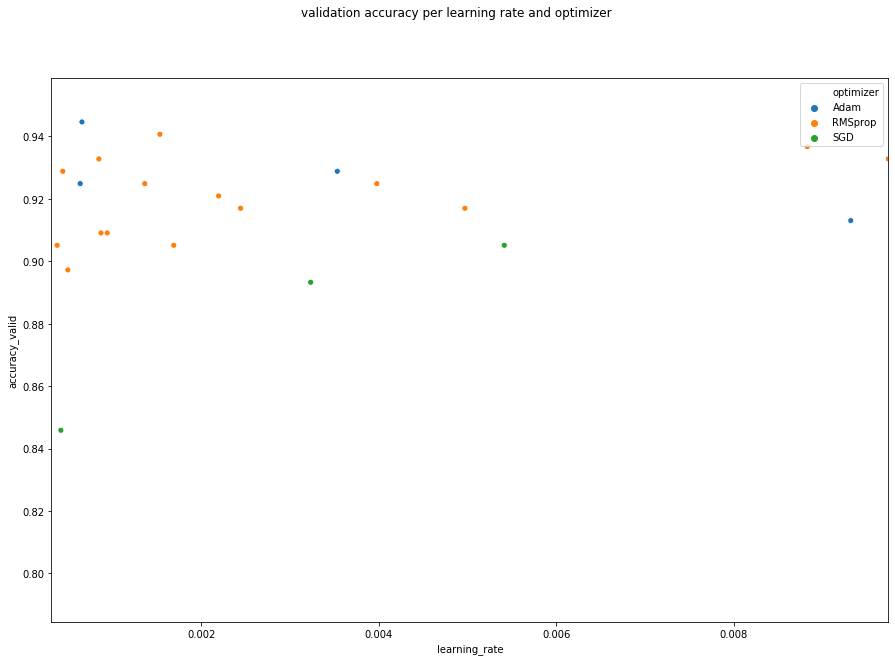

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
fig.suptitle('validation accuracy per learning rate and optimizer')
ax.set_xlim([df['learning_rate'].min() * 30,df['learning_rate'].max()])

sns.scatterplot(x=d['learning_rate'], y=d['accuracy_valid'], hue=d['optimizer'], ax=ax)

# Transfer Learning

In [21]:
experiment_names = [
    "cloud_and_shadow_resnet_v2_with_aug_early_stopping_20_lr_3e-4_2020_2_08",
    "cloud_and_shadow_resnet_v2_with_aug_early_stopping_15_2020_2_08",
    "cloud_and_shadow_resnet_v2_with_aug_2020_2_08",
    "cloud_and_shadow_inception_v3_with_aug_2020_2_08",
    "cloud_and_shadow_inception_v3_with_aug_lr_1e-6_2020_2_08",    
]

In [22]:
models = {}
all_metadata = {}
for experiment_name in experiment_names:
    model, metadata = get_model_and_metadata_from_gcs(
        bucket, model_dir, "h5", load_model, gcs_model_dir, experiment_name)
    models[experiment_name] = model
    all_metadata[experiment_name] = metadata

In [23]:
keys = ['experiment_name', 'n_epochs', 'epochs_trained', 'learning_rate', 'early_stopping_patience', 'elapsed_train_time', 'accuracy_valid', 
        'accuracy_train', 'f1_score_train', 'f1_score_valid',
        'loss']
df = pd.DataFrame([{key: metadata.get(key) for key in keys} for metadata in all_metadata.values()])

In [24]:
df

,experiment_name,n_epochs,epochs_trained,learning_rate,early_stopping_patience,elapsed_train_time,accuracy_valid,accuracy_train,f1_score_train,f1_score_valid,loss
0,cloud_and_shadow_resnet_v2_with_aug_early_stop...,60,None,0.000300,20,1523.747414,0.920949,0.890404,0.884211,0.909910,0.410663
1,cloud_and_shadow_resnet_v2_with_aug_early_stop...,60,None,0.000010,15,258.553391,0.857708,0.856843,0.857887,0.843478,0.387534
2,cloud_and_shadow_resnet_v2_with_aug_2020_2_08,60,None,0.000010,7,550.462309,0.869565,0.854221,0.858883,0.863071,0.341035
3,cloud_and_shadow_inception_v3_with_aug_2020_2_08,60,None,0.000010,20,454.064497,NaN,NaN,NaN,NaN,NaN
4,cloud_and_shadow_inception_v3_with_aug_lr_1e-6...,60,None,0.000001,7,799.606526,0.770751,0.753015,0.782448,0.780303,0.574763


In [13]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/app/.gcs/big-earth-252219-fb2e5c109f78.json'
gcs_client = storage.Client()
bucket = gcs_client.bucket("big_earth")
# blob = bucket.blob('model/hyperparameter_opt_record/learning_rate_batch_size_optimizer_2020_2_13.json')
blob = bucket.blob('model/models/cloud_and_shadow_cnn_bn_hopt_lr_0.00063454_optimizer_Adam_2020_2_13_metadata.json')

local_filename = 'learning_rate_batch_size_optimizer_2020_2_13.json'
blob.download_to_filename(local_filename)

with open(local_filename) as fileobj:
    hyperopt_results = json.load(fileobj)

In [23]:
hyperopt_results

{'data': 'train_valid_google_automl_cloud_and_shadow_dataset_small.csv',
 'data_prep': 'normalization_augmentation',
 'experiment_name': 'cloud_and_shadow_cnn_bn_hopt_lr_0.00063454_optimizer_Adam_2020_2_13',
 'experiment_start_time': '2020-02-13 21:40',
 'model': 'keras_cnn_bn',
 'random_state': 0,
 'epoch_with_best_model': '32',
 'epochs_trained': 5,
 'optimizer': 'Adam',
 'n_epochs': 60,
 'early_stopping_patience': 20,
 'learning_rate': 0.0006345350619938715,
 'history': {'loss': [0.6459183693713522,
   0.3883658071025604,
   0.344503782513758,
   0.3075840616482493,
   0.2913976784270036,
   0.2838747330717098,
   0.2851769068069838,
   0.2910550765392351,
   0.2875771522053137,
   0.27679182839881206,
   0.26596478740457596,
   0.26832320779858926,
   0.25531130698599863,
   0.2387933102136016,
   0.26330467678047814,
   0.25092500427910713,
   0.22590870609068409,
   0.24207164494855027,
   0.23150921902484023,
   0.21959953823512177,
   0.2434546693682858,
   0.2228596210948572,


In [18]:
# hopt = pd.DataFrame([trial['result'] for trial in hyperopt_results['trials']])
# hopt.columns

hopt[['experiment_name', 'accuracy_train', 'accuracy_valid', 
      'epoch_with_best_model', 'elapsed_train_time', 'epochs_trained', 'n_epochs', 
      'learning_rate', 'optimizer', ]]

TypeError: unhashable type: 'list'